# Self-Driving Car Engineer Nanodegree


## Project: **Finding Lane Lines on the Road** 
***

## Import Packages

In [1]:
#importing some useful packages
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
import cv2
%matplotlib inline

## Helper and custom functions

In [2]:
import math

def grayscale(img):
    """Applies the Grayscale transform
    This will return an image with only one color channel
    but NOTE: to see the returned image as grayscale
    (assuming your grayscaled image is called 'gray')
    you should call plt.imshow(gray, cmap='gray')"""
    return cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    # Or use BGR2GRAY if you read an image with cv2.imread()
    # return cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    
def canny(img, low_threshold, high_threshold):
    """Applies the Canny transform"""
    return cv2.Canny(img, low_threshold, high_threshold)

def gaussian_blur(img, kernel_size):
    """Applies a Gaussian Noise kernel"""
    return cv2.GaussianBlur(img, (kernel_size, kernel_size), 0)

def region_of_interest(img, vertices):
    """
    Applies an image mask.
    
    Only keeps the region of the image defined by the polygon
    formed from `vertices`. The rest of the image is set to black.
    """
    #defining a blank mask to start with
    mask = np.zeros_like(img)   
    
    #defining a 3 channel or 1 channel color to fill the mask with depending on the input image
    if len(img.shape) > 2:
        channel_count = img.shape[2]  # i.e. 3 or 4 depending on your image
        ignore_mask_color = (255,) * channel_count
    else:
        ignore_mask_color = 255
        
    #filling pixels inside the polygon defined by "vertices" with the fill color    
    cv2.fillPoly(mask, vertices, ignore_mask_color)
    
    #returning the image only where mask pixels are nonzero
    masked_image = cv2.bitwise_and(img, mask)
    return masked_image

def draw_lines(img, lines, color=[255, 0, 0], thickness=2, vertices=None, extr_vert=None):
    """
    This function draws `lines` with `color` and `thickness`.    
    Lines are drawn on the image inplace (mutates the image).
    If you want to make the lines semi-transparent, think about combining
    this function with the weighted_img() function below
    """
    for line in lines:
        for x1,y1,x2,y2 in line:
            cv2.line(img, (x1, y1), (x2, y2), color, thickness)   

def draw_lines_extrapolated(img, lines, color=[255, 0, 0], thickness=10, vertices=None, extr_vert=0.6):
    """
    This function fits one line to each lane, based on `lines`, with `color` and `thickness`.  
    'extr_vert' indicates up to which extent of the vertical dimension should the line be extrapolated.
    'vertices' is used to locate the line endpoints with respect to the ROI, and use it with 
    outlier detection purposes
    Lines are drawn on the image inplace (mutates the image).
    """
    x_l_list = list()
    y_l_list = list()
    x_r_list = list()
    y_r_list = list()
    # Get the 4 vertices from the ROI
    vertices = vertices.reshape(4,2)
    # To assign a line as part of the left/right lane, 3 conditions are checked:
    # - sign of the slope
    # - horizontal position of the line midpoint with respect to the ROI's top edge midpoint
    # - slope is in a reasonable range (here 45deg +- 20)
    # The 2 latter are passive conditions for excluding outliers
    # After classifying and filtering outliers, store the line endpoint coordinates in separate 
    # lists for left/right lanes
    for line in lines:
        for x1,y1,x2,y2 in line:
            slope = (y2 - y1)/(x2 - x1)
            if (slope < 0) and ((x1+x2)/2 < vertices[2:,0].mean() and abs(np.arctan(-slope) - 45*np.pi/180) < 20*np.pi/180):
                x_l_list += [x1,x2]
                y_l_list += [y1,y2]
            elif (slope > 0) and ((x1+x2)/2 > vertices[2:,0].mean() and abs(np.arctan(slope) - 45*np.pi/180) < 20*np.pi/180):
                x_r_list += [x1,x2]
                y_r_list += [y1,y2]
    
    # Get linear fit for the left lane, using the line endpoints that were marked as left-lane
    # (regressing x against y)
    x_l = np.array(x_l_list)
    y_l = np.array(y_l_list)
    A_l = np.vstack([y_l, np.ones_like(y_l)]).T
    m_l, c_l = np.linalg.lstsq(A_l, x_l)[0] # slope and independent term
    
    # Get linear fit for the right lane, using the line endpoints that were marked as right-lane
    # (regressing x against y)
    x_r = np.array(x_r_list)
    y_r = np.array(y_r_list)
    A_r = np.vstack([y_r, np.ones_like(y_r)]).T  
    m_r, c_r = np.linalg.lstsq(A_r, x_r)[0] # slope and independent term
    
    # Function to evaluate x = f(y)
    eval_f = lambda x,m,c: int(x*m + c)
    
    # Extrapolate from the bottom of the image, to the given extent 'extr_vert'
    y_low = img.shape[0]
    y_up = int(extr_vert*img.shape[0])
    
    # Evaluate endpoints and generate lines
    x_l_low = eval_f(y_low,m_l,c_l)
    x_l_up = eval_f(y_up,m_l,c_l)
    x_r_low = eval_f(y_low,m_r,c_r)
    x_r_up = eval_f(y_up,m_r,c_r)
    
    cv2.line(img,(x_l_low,y_low),(x_l_up,y_up),color,thickness)
    cv2.line(img,(x_r_low,y_low),(x_r_up,y_up),color,thickness)

    
def hough_lines(img, rho, theta, threshold, min_line_len, max_line_gap, 
                vertices=None, extr_vert=None, extrap=True):
    """
    `img` should be the output of a Canny transform.
        
    Returns an image with hough lines drawn (extrap=False) or the extrapolated lines (extrap=True).
    """
    lines = cv2.HoughLinesP(img, rho, theta, threshold, np.array([]), minLineLength=min_line_len, maxLineGap=max_line_gap)
    line_img = np.zeros((img.shape[0], img.shape[1], 3), dtype=np.uint8)
    # Use the default draw lines function, or the new custom one.
    dl = draw_lines if not extrap else draw_lines_extrapolated
    dl(line_img, lines, vertices=vertices)
    return line_img

def weighted_img(img, initial_img, α=0.8, β=1., λ=0.):
    """
    `img` is the output of the hough_lines(), An image with lines drawn on it.
    Should be a blank image (all black) with lines drawn on it.
    
    `initial_img` should be the image before any processing.
    
    The result image is computed as follows:
    
    initial_img * α + img * β + λ
    NOTE: initial_img and img must be the same shape!
    """
    return cv2.addWeighted(initial_img, α, img, β, λ)

# Building the pipeline

The white_road boolean flag is set to True when we are treating the challenge case, where there is a interval of clear tarmac (lanes are barelly distinguished)

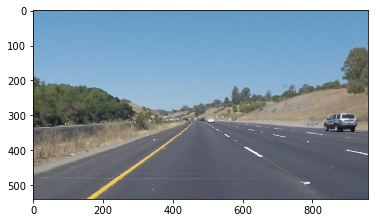

In [3]:
white_road=False
image = mpimg.imread('test_images/solidYellowCurve.jpg')
plt.imshow(image);

---
If the road is pale, we need to highlight the white and yellow pixels. I perform a gamma correction.

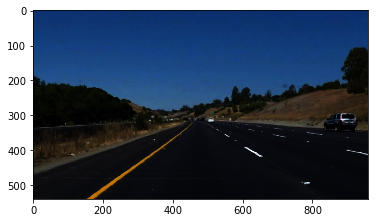

In [4]:
def adjust_gamma(image, gamma=0.30):
    # build a lookup table mapping the pixel values [0, 255] to
    # their adjusted gamma values
    invGamma = 1.0 / gamma
    table = np.array([((i / 255.0) ** invGamma) * 255
        for i in np.arange(0, 256)]).astype("uint8")

    # apply gamma correction using the lookup table
    return cv2.LUT(image, table)
plt.imshow(adjust_gamma(image));

---

Greyscale the image, apply Gaussian noise kernel, and the Canny edge detection algorithm.

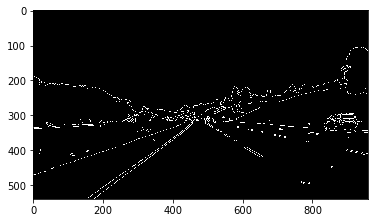

In [5]:
tr = 50
img =  image if not white_road else adjust_gamma(image)
wy_gray = grayscale(img)
blur_gray = gaussian_blur(wy_gray,5)
edges = canny(blur_gray,tr,tr*3)
plt.imshow(edges, cmap='Greys_r');

Define 4-edge ROI, and perform the masking:

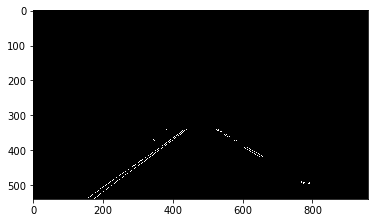

In [6]:
v_bottom = int(1*image.shape[0])
v_top = int(0.63*image.shape[0])
h1_bottom = int(0.1*image.shape[1])
h2_bottom = int(1.0*image.shape[1])
h1_top = int(0.4*image.shape[1])
h2_top = int(0.6*image.shape[1])
vertices = np.array([[
    [h1_bottom,v_bottom],
    [h2_bottom,v_bottom],
    [h2_top,v_top],
    [h1_top,v_top]
]],dtype=np.int32)

masked_edges = region_of_interest(edges,vertices)
plt.imshow(masked_edges, cmap='Greys_r');

Perform Hough transform and get the detected lines:

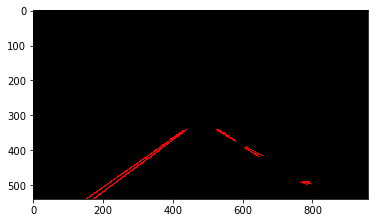

In [7]:
lines_edges = hough_lines(masked_edges,
                          rho=1,
                          theta=np.pi/180,
                          threshold=10,
                          min_line_len=10,
                          max_line_gap=15, 
                          extr_vert=0.6,
                          vertices=vertices,
                          extrap=False)
plt.imshow(lines_edges);

Perform Hough transform, get the detected lines, and average/extrapolate the given lines:

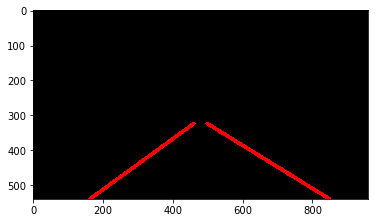

In [8]:
lines_edges = hough_lines(masked_edges,
                          rho=1,
                          theta=np.pi/180,
                          threshold=10,
                          min_line_len=10,
                          max_line_gap=15, 
                          extr_vert=0.6,
                          vertices=vertices,
                          extrap=True)
plt.imshow(lines_edges);

# Pipeline encapsulation

In [9]:
def pipeline(image, roi_params, pale_road=False, extrap=False,**kwargs):
    if pale_road:
        img = adjust_gamma(image)
    else:
        img = np.copy(image)
    gray = grayscale(img)
    blur_gray = gaussian_blur(gray,kwargs['kernel_size'])
    edges = canny(blur_gray,kwargs['canny_low'],kwargs['canny_high'])
    v_bottom = roi_params[0][0]*image.shape[0]
    v_top = roi_params[0][1]*image.shape[0]
    h1_bottom = roi_params[1][0]*image.shape[1]
    h2_bottom = roi_params[1][1]*image.shape[1]
    h1_top = roi_params[1][2]*image.shape[1]
    h2_top = roi_params[1][3]*image.shape[1]
    vertices = np.array([[
        [h1_bottom,v_bottom],
        [h2_bottom,v_bottom],
        [h2_top,v_top],
        [h1_top,v_top]
    ]],dtype=np.int32)

    masked_edges = region_of_interest(edges,vertices)
    lines_edges = hough_lines(masked_edges,
                         rho=kwargs['rho'],
                         theta=kwargs['theta'],
                         threshold=kwargs['hough_threshold'],
                         min_line_len=kwargs['hough_min_line_len'],
                         max_line_gap=kwargs['hough_max_line_gap'],
                         extrap=extrap, vertices=vertices)
    return weighted_img(lines_edges, image, α=0.9, β=1., λ=0.)

Checking the encapsulation works, on a static image:

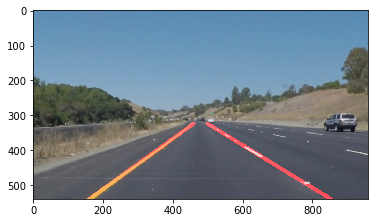

In [10]:
roi_params = ((1, 0.63),(0.1, 1.0, 0.43, 0.6))
plt.imshow(
    pipeline(
        image, 
        roi_params=roi_params,
        kernel_size=5,
        canny_low=50, canny_high=140,
        rho=1, theta=1*np.pi/180, 
        hough_threshold=10,
        hough_min_line_len=10, 
        hough_max_line_gap=15,
        pale_road=False,
        extrap=True
    )
);

# Video CASE 1: annotating with Hough lines

In [11]:
from moviepy.editor import VideoFileClip
from IPython.display import HTML

In [12]:
def process_image_1(image):
    roi_params = ((1, 0.63),(0.1, 1.0, 0.43, 0.6))
    result = pipeline(
        image, 
        roi_params=roi_params,
        kernel_size=5,
        canny_low=50, canny_high=140,
        rho=1, theta=1*np.pi/180, 
        hough_threshold=20,
        hough_min_line_len=20, 
        hough_max_line_gap=15,
        pale_road=False,
        extrap=False
    )
    return result

In [13]:
white_output = 'white.mp4'
clip1 = VideoFileClip("video_inputs/solidWhiteRight.mp4")
white_clip = clip1.fl_image(process_image_1) #NOTE: this function expects color images!!
%time white_clip.write_videofile(white_output, audio=False)

[MoviePy] >>>> Building video white.mp4
[MoviePy] Writing video white.mp4


100%|█████████▉| 221/222 [00:02<00:00, 82.46it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: white.mp4 

Wall time: 3.14 s


In [14]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(white_output))

# Video - CASE 2: annotating with extrapolation of the Hough lines

In [15]:
def process_image_2(image):
    roi_params = ((1, 0.63),(0.1, 1.0, 0.43, 0.6))
    result = pipeline(
        image, 
        roi_params=roi_params,
        kernel_size=5,
        canny_low=50, canny_high=140,
        rho=1, theta=1*np.pi/180, 
        hough_threshold=20,
        hough_min_line_len=20, 
        hough_max_line_gap=15,
        pale_road=False,
        extrap=True
    )
    return result

In [16]:
yellow_output = 'yellow.mp4'
clip2 = VideoFileClip('video_inputs/solidYellowLeft.mp4')
yellow_clip = clip2.fl_image(process_image_2)
%time yellow_clip.write_videofile(yellow_output, audio=False)

[MoviePy] >>>> Building video yellow.mp4
[MoviePy] Writing video yellow.mp4


100%|█████████▉| 681/682 [00:08<00:00, 77.97it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: yellow.mp4 

Wall time: 9.21 s


In [17]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(yellow_output))

# Video - CASE CHALLENGE: annotating with extrapolation of the Hough lines

In [18]:
def process_image_challenge(image):
    roi_params = ((0.91, 0.64),(0.15, 0.9, 0.4, 0.65))
    result = pipeline(
        image, 
        roi_params=roi_params,
        kernel_size=9,
        canny_low=30, canny_high=90,
        rho=1, theta=1*np.pi/180, 
        hough_threshold=30,
        hough_min_line_len=2, 
        hough_max_line_gap=5,
        pale_road=True,
        extrap=True
    )
    return result

In [19]:
challenge_output = 'extra.mp4'
clip2 = VideoFileClip('video_inputs/challenge.mp4')
challenge_clip = clip2.fl_image(process_image_challenge)
%time challenge_clip.write_videofile(challenge_output, audio=False)

[MoviePy] >>>> Building video extra.mp4
[MoviePy] Writing video extra.mp4


100%|██████████| 251/251 [00:06<00:00, 38.01it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: extra.mp4 

Wall time: 7.37 s


In [20]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(challenge_output))